In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
sql = spark.SQLContext(sc)
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
#Load the data
from google.colab import files
uploaded = files.upload()

Saving LMS.csv to LMS.csv


In [ ]:
#Single Feature Sentiment Analysis
df = pd.read_csv('LMS.csv')
df.columns = ['date','Sentiment_score','Price']
df.head()

,date,Sentiment_score,Price
0,2023-01-03,-0.2500,16679.85742
1,2023-01-04,0.0000,16863.23828
2,2023-01-05,0.0000,16836.73633
3,2023-01-06,0.3806,16951.96875
4,2023-01-07,0.7579,16955.07813


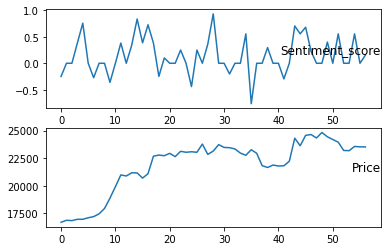

In [ ]:
#Plotting the input variables
values = df.values
# specify columns to plot
groups = [ 1,2]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [ ]:
df.set_index('date',inplace=True)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,Price,Sentiment_score
date,,
2023-01-03,16679.85742,-0.2500
2023-01-04,16863.23828,0.0000
2023-01-05,16836.73633,0.0000
2023-01-06,16951.96875,0.3806
2023-01-07,16955.07813,0.7579
2023-01-08,17091.14453,0.0000
2023-01-09,17196.55469,-0.2732
2023-01-10,17446.29297,0.0000
2023-01-11,17934.89648,0.0000


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_days = 1  #no of time lags
n_features = 1 #no of features
n_obs = n_days*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_days, 1)
reframed.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.000000,0.302886,0.022503,0.450118
2,0.022503,0.450118,0.019251,0.450118
3,0.019251,0.450118,0.033391,0.674264
4,0.033391,0.674264,0.033772,0.896466
5,0.033772,0.896466,0.050469,0.450118


In [ ]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var1(t)
1,0.000000,0.302886,0.022503
2,0.022503,0.450118,0.019251
3,0.019251,0.450118,0.033391
4,0.033391,0.674264,0.033772
5,0.033772,0.896466,0.050469


In [ ]:
values = reframed.values
n_train_days = 2
train = values[:n_train_days, :]
test = values[n_train_days:, :]
train.shape

(2, 3)

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2, 1, 1) (2,) (54, 1, 1) (54,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/20
1/1 - 3s - loss: 0.0196 - val_loss: 0.5881 - 3s/epoch - 3s/step
Epoch 2/20
1/1 - 0s - loss: 0.0179 - val_loss: 0.5855 - 92ms/epoch - 92ms/step
Epoch 3/20
1/1 - 0s - loss: 0.0162 - val_loss: 0.5829 - 93ms/epoch - 93ms/step
Epoch 4/20
1/1 - 0s - loss: 0.0145 - val_loss: 0.5803 - 102ms/epoch - 102ms/step
Epoch 5/20
1/1 - 0s - loss: 0.0128 - val_loss: 0.5777 - 50ms/epoch - 50ms/step
Epoch 6/20
1/1 - 0s - loss: 0.0111 - val_loss: 0.5751 - 55ms/epoch - 55ms/step
Epoch 7/20
1/1 - 0s - loss: 0.0094 - val_loss: 0.5725 - 53ms/epoch - 53ms/step
Epoch 8/20
1/1 - 0s - loss: 0.0077 - val_loss: 0.5699 - 91ms/epoch - 91ms/step
Epoch 9/20
1/1 - 0s - loss: 0.0060 - val_loss: 0.5674 - 54ms/epoch - 54ms/step
Epoch 10/20
1/1 - 0s - loss: 0.0043 - val_loss: 0.5648 - 54ms/epoch - 54ms/step
Epoch 11/20
1/1 - 0s - loss: 0.0031 - val_loss: 0.5627 - 91ms/epoch - 91ms/step
Epoch 12/20
1/1 - 0s - loss: 0.0031 - val_loss: 0.5609 - 93ms/epoch - 93ms/step
Epoch 13/20
1/1 - 0s - loss: 0.0031 - val_loss: 0.5

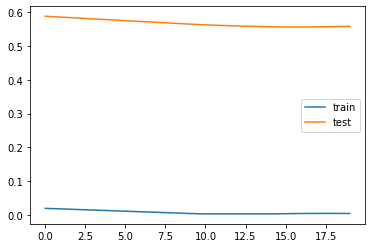

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 10ms/step
Test RMSE: 4895.639


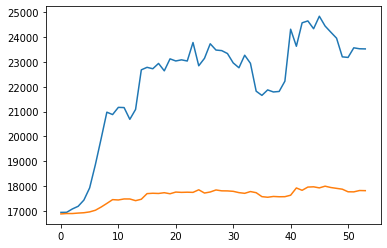

In [ ]:
plt.plot(inv_y)
plt.plot(inv_yhat)

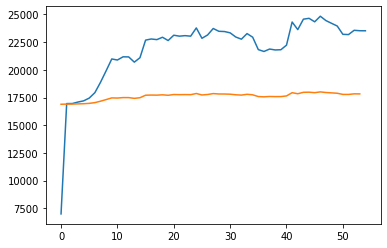

In [ ]:
inv_y = np.insert(inv_y,0,7000)
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()